## Importing Libraries

In [1]:
import cv2
import numpy as np
import os
import pytesseract as pt
import matplotlib.pyplot as plt

In [2]:
pt.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [3]:
# !pip install pytesseract
# !pip install tesseract
# !pip install tesseract-ocr

In [4]:
# settings 
INPUT_WIDTH = 640
INPUT_HEIGHT = 640

## Loading the image to be detected

(-0.5, 599.5, 479.5, -0.5)

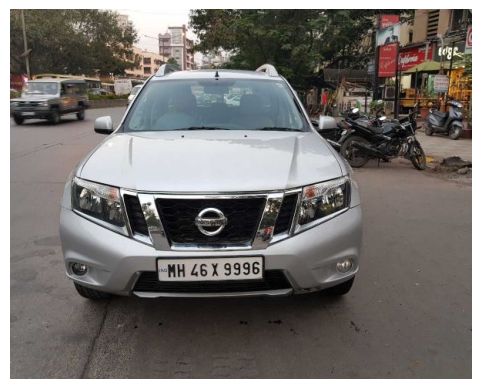

In [5]:
img = cv2.imread("./Verification/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

## Loading the trained YOLOv5 model

In [6]:
net = cv2.dnn.readNetFromONNX("./Model-YOLOv5-Collab/Model/weights/best.onnx")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

## Converting image to YOLO Format generating the predictions

(-0.5, 599.5, 599.5, -0.5)

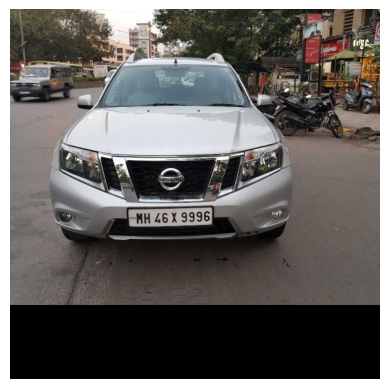

In [7]:
image = img.copy()
row, col, d = image.shape

max_rc = max(row, col)
input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)
input_image[0:row, 0:col] = image
plt.imshow(input_image)
plt.axis("off")

In [8]:
blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
net.setInput(blob)
preds = net.forward()
detections = preds[0]

In [9]:
detections.shape

(25200, 6)

## Filtering the detection based on the confidence and probability scores

In [10]:
boxes = []
confidences = []

image_w, image_h = input_image.shape[:2]
x_factor = image_w / INPUT_WIDTH
y_factor = image_h / INPUT_HEIGHT

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4]
    if confidence > 0.4:
        class_score = row[5]
        if class_score > 0.25:
            cx, cy, w, h = row[0:4]
            
            left = int((cx - 0.5 * w) * x_factor)
            top = int((cy - 0.5 * h) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)
            box = np.array([left,top,width,height])
            
            confidences.append(confidence)
            boxes.append(box)

In [11]:
boxes[:5]

[array([188, 322, 139,  32]),
 array([189, 321, 140,  32]),
 array([189, 321, 141,  34]),
 array([188, 322, 141,  31]),
 array([189, 321, 141,  32])]

In [12]:
# Clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

In [13]:
boxes_np[:5]

[[188, 322, 139, 32],
 [189, 321, 140, 32],
 [189, 321, 141, 34],
 [188, 322, 141, 31],
 [189, 321, 141, 32]]

In [14]:
confidences_np[:5]

[0.7020074129104614,
 0.8615354895591736,
 0.583177387714386,
 0.5094260573387146,
 0.6944117546081543]

In [15]:
index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45).flatten()

In [16]:
index

array([1])

## Drawing the detected bounding box

ran


(-0.5, 599.5, 479.5, -0.5)

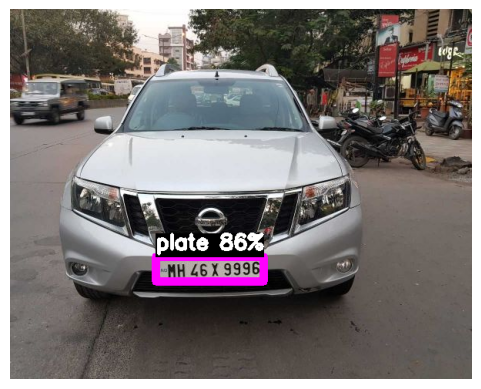

In [17]:
for ind in index:
    print("ran")
    x,y,w,h = boxes_np[ind]
    bb_conf = confidences_np[ind]
    conf_text = "plate {:.0f}%".format(bb_conf*100)

    
    cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,255), 10)
    cv2.rectangle(image, (x,y-30), (x+w, y), (0, 0, 0),-1)
    
    cv2.putText(image, conf_text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255),3)
    
plt.imshow(image)
plt.axis("off")